In [1]:
import xml.etree.ElementTree as ET
import glob
import os
import json

Converting PASCAL xml to YOLO

In [2]:
#defining a function to convert pascal coordinates to yolo (normalised)
def xml_to_yolo_bbox(bbox, w, h):
    # xmin, ymin, xmax, ymax
    x_center = ((bbox[2] + bbox[0]) / 2) / w
    y_center = ((bbox[3] + bbox[1]) / 2) / h
    width = (bbox[2] - bbox[0]) / w
    height = (bbox[3] - bbox[1]) / h
    return [x_center, y_center, width, height]

In [5]:
#initialising the classes and directory to store yolo labels
classes = ["head", "helmet"]
input_dir = "annotations/"
output_dir = "labels/"
image_dir = "images/"
os.mkdir(output_dir)


In [22]:
files = glob.glob(os.path.join(input_dir, '*.xml'))
# loop through each 
for fil in files:
    basename = os.path.basename(fil)
    filename = os.path.splitext(basename)[0]
    # check if the label contains the corresponding image file
    if not os.path.exists(os.path.join(image_dir, f"{filename}.png")):
        print(f"{filename} image does not exist!")
        continue


In [25]:
print(os.path.join(image_dir, f"{filename}.png"))
print(os.path.exists(os.path.join(image_dir, f"{filename}.png")))

images/hard_hat_workers3334.png
True


In [26]:
#I went through each xml file parse the coordinate and class name, and then convert it into yolo format
files = glob.glob(os.path.join(input_dir, '*.xml'))

for fil in files:
    
    basename = os.path.basename(fil)
    filename = os.path.splitext(basename)[0]
    result = []
    tree = ET.parse(fil)
    root = tree.getroot()
    width = int(root.find("size").find("width").text)
    height = int(root.find("size").find("height").text)
    for obj in root.findall('object'):
        label = obj.find("name").text
        if label not in classes:
            classes.append(label)
        index = classes.index(label)
        pil_bbox = [int(x.text) for x in obj.find("bndbox")]
        yolo_bbox = xml_to_yolo_bbox(pil_bbox, width, height)
        bbox_string = " ".join([str(x) for x in yolo_bbox])
        result.append(f"{index} {bbox_string}")
    if result:
        with open(os.path.join(output_dir, f"{filename}.txt"), "w", encoding="utf-8") as f:
            f.write("\n".join(result))
    
    with open('classes.txt', 'w', encoding='utf8') as f:
        f.write(json.dumps(classes))

In [27]:
#cloning YOLOv5 model 
!git clone https://github.com/ultralytics/yolov5

Cloning into 'yolov5'...
remote: Enumerating objects: 12130, done.
remote: Counting objects: 100% (83/83), done.
remote: Compressing objects: 100% (57/57), done.
remote: Total 12130 (delta 45), reused 54 (delta 26), pack-reused 12047
Receiving objects: 100% (12130/12130), 12.59 MiB | 1.27 MiB/s, done.
Resolving deltas: 100% (8333/8333), done.


In [1]:
import torch
from matplotlib import pyplot as plt
import numpy as np
import cv2

Loading the YOLOv5 pretrained model

In [2]:
model = torch.hub.load('ultralytics/yolov5', 'yolov5s')

Using cache found in /Users/yazeedshamsudeen/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2022-8-21 Python-3.9.12 torch-1.12.1 CPU



  0%|          | 0.00/14.1M [00:00<?, ?B/s]


Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


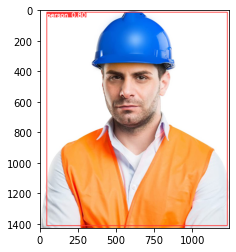

In [3]:
img = 'https://m.media-amazon.com/images/I/61xPbeMDAwL._AC_SL1500_.jpg'
results = model(img)
%matplotlib inline 
plt.imshow(np.squeeze(results.render()))
plt.show()

Training my custom model with given dataset

In [9]:
#i used 10 epochs to train because i didnt have a GPU, 50-100 epochs would give better result
os.environ['KMP_DUPLICATE_LIB_OK']='True'
!cd yolov5 && python train.py --img 320 --batch 16 --epochs 10 --data dataset.yml --weights yolov5s.pt

train: weights=yolov5s.pt, cfg=, data=dataset.yml, hyp=data/hyps/hyp.scratch-low.yaml, epochs=10, batch_size=16, imgsz=320, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=None, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=runs/train, name=exp, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, seed=0, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: up to date with https://github.com/ultralytics/yolov5 ✅
YOLOv5 🚀 v6.2-80-g55b0096 Python-3.9.12 torch-1.12.1 CPU

hyperparameters: lr0=0.01, lrf=0.01, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1, box=0.05, cls=0.5, cls_pw=1.0, obj=1.0, obj_pw=1.0, iou_t=0.2, anchor_t=4.0, fl_gamma=0.0, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, degrees=0.0, translate=0.1, sca

Step1 Evaluation

In [10]:
model = torch.hub.load('ultralytics/yolov5', 'custom', path='yolov5/runs/train/exp4/weights/last.pt', force_reload=True)

Downloading: "https://github.com/ultralytics/yolov5/zipball/master" to /Users/yazeedshamsudeen/.cache/torch/hub/master.zip
YOLOv5 🚀 2022-9-1 Python-3.9.12 torch-1.12.1 CPU

Fusing layers... 
Model summary: 213 layers, 7018216 parameters, 0 gradients, 15.8 GFLOPs
Adding AutoShape... 


In [13]:
img = os.path.join('data', 'images', 'hard_hat_workers10.png')
results = model(img)
results.print()

image 1/1: 416x416 3 helmets
Speed: 16.0ms pre-process, 304.7ms inference, 0.8ms NMS per image at shape (1, 3, 640, 640)


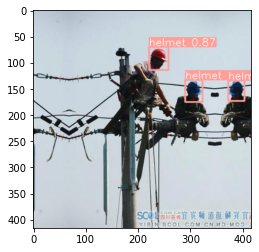

In [14]:
%matplotlib inline 
plt.imshow(np.squeeze(results.render()))
plt.show()

In [15]:
cap = cv2.VideoCapture('samplevideo.mp4')
while cap.isOpened():
    ret, frame = cap.read()
    
    # Make detections 
    results = model(frame)
    
    
    cv2.imshow('YOLO', np.squeeze(results.render()))
    
    if cv2.waitKey(10) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

Stage 2: Find the color

In [193]:
import math
def unique_count_app(a):
    '''
    a: NumPy array i.e. the ROI from your image
    Returns: tuple (r, g, b)
    '''
    colors, count = np.unique(a.reshape(-1, a.shape[-1]), axis=0, return_counts=True)
    return colors[count.argmax()]


"""
sample code for exctracting bounding box coordinates,
detecting the color of hat and redrawing the bounding box with
identified color 
"""
img = os.path.join('data', 'images', 'hard_hat_workers16.png')
img = cv2.imread(img)
results = model(img)
df = results.pandas().xyxy[0]
for i in range(len(df.index)):
    x1 = df.iloc[i]['xmin']
    y1 = df.iloc[i]['ymin']
    x2 = df.iloc[i]['xmax']
    y2 = df.iloc[i]['ymax']
    confidence = df.iloc[i]['confidence']
    name = df.iloc[i]['name']
    
    #i cropped the image to 25% to get the top area where the hat usually present
    factor = 4
    _y2 = y2 - (y2 - y1) // 4
    
    x1 = math.floor(x1)
    y1 = math.floor(y1)
    x2 = math.floor(x2)
    _y2 = math.floor(_y2)
    _x1 = math.floor(_x1)
    _x2 = math.floor(_x2)
    
    #cropping the image
    crop = img[y1:_y2, x1:x2]
    color = unique_count_app(crop) #this function returns the max occuring color in the cropped area
    
    c = (int(color[0]),int(color[1]),int(color[2]))
    #drawing the rectangle with identified color
    img = cv2.rectangle(img, (x1,y1), (x2,math.floor(y2)), c, 2)
    confidence = round(confidence,2)
    img = cv2.putText(img, name+' '+str(confidence), (x1-10,y1-10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, c, 2)
    cv2.imshow('yolo', img)
    print(color)
    
    cv2.waitKey(0)
    cv2.destroyAllWindows()


    
#cv2.imshow('yolo', np.squeeze(results.render()))
#cv2.waitKey(0)
#cv2.destroyAllWindows()




[ 83 226 247]
[199 197 196]
[165 166 164]
[ 83 226 247]
[ 83 226 247]


In [192]:
#the above sample code is implemented here and tested in a video
cap = cv2.VideoCapture('samplevideo.mp4')
while cap.isOpened():
    ret, img = cap.read()
    
    results = model(img)
    df = results.pandas().xyxy[0]
    for i in range(len(df.index)):
        x1 = df.iloc[i]['xmin']
        y1 = df.iloc[i]['ymin']
        x2 = df.iloc[i]['xmax']
        y2 = df.iloc[i]['ymax']
        confidence = df.iloc[i]['confidence']
        name = df.iloc[i]['name']
        factor = 4
        _y2 = y2 - (y2 - y1) // 4
        x1 = math.floor(x1)
        y1 = math.floor(y1)
        x2 = math.floor(x2)
        _y2 = math.floor(_y2)
        crop = img[y1:_y2, x1:x2]
        color = unique_count_app(crop)
        c = (int(color[0]),int(color[1]),int(color[2]))
        img = cv2.rectangle(img, (x1,y1), (x2,math.floor(y2)), c, 2)
        confidence = round(confidence,2)
        img = cv2.putText(img, name+' '+str(confidence), (x1-10,y1-10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, c, 2)
    
    
    cv2.imshow('YOLO', img)
    
    if cv2.waitKey(10) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

Stage 3: creating PASCAL xml Files for test set

In [6]:
import torch
model = torch.hub.load('ultralytics/yolov5', 'custom', path='yolov5/runs/train/exp4/weights/last.pt', force_reload=True)

Downloading: "https://github.com/ultralytics/yolov5/zipball/master" to /Users/yazeedshamsudeen/.cache/torch/hub/master.zip
YOLOv5 🚀 2022-9-2 Python-3.9.12 torch-1.12.1 CPU

Fusing layers... 
Model summary: 213 layers, 7018216 parameters, 0 gradients, 15.8 GFLOPs
Adding AutoShape... 


In [10]:
import numpy as np
import cv2
img = os.path.join('data', 'test', 'hard_hat_workers12.png')
img = cv2.imread(img)
results = model(img)
cv2.imshow('yolo', np.squeeze(results.render()))
cv2.waitKey(0)
cv2.destroyAllWindows()

Labelling the test images in PASCAL VOC

In [ ]:
from PIL import Image
import math
directory = 'data/test'

#looping through each test image file
for filename in os.listdir(directory):
    img = os.path.join(directory, filename)
    #extracting coordinates and class name from the result
    results = model(img)
    df = results.pandas().xyxy[0]
    orig_img = Image.open(img) # open the image
    image_width = orig_img.width
    image_height = orig_img.height
    try:
        #a xml file is created with same name as the image
        with open('testlabels/'+filename.replace('png', 'xml'), 'w') as f:
            f.write('<annotation>\n')
            f.write('\t<folder>testlabels</folder>\n')
            f.write('\t<size>\n')
            f.write('\t\t<width>' + str(image_width) + '</width>\n')
            f.write('\t\t<height>' + str(image_height) + '</height>\n')
            f.write('\t\t<depth>3</depth>\n') # assuming a 3 channel color image (RGB)
            f.write('\t</size>\n')
            f.write('\t<segmented>0</segmented>\n')
            if len(df.index) == 0:
                f.write('</annotation>\n')
                f.close()
                continue
            #looping through the result dataframe and exctrating each bounding box information
            for i in range(len(df.index)):
                x1 = df.iloc[i]['xmin']
                y1 = df.iloc[i]['ymin']
                x2 = df.iloc[i]['xmax']
                y2 = df.iloc[i]['ymax']
                x1 = math.floor(x1)
                y1 = math.floor(y1)
                x2 = math.floor(x2)
                y2 = math.floor(y2)
                name = df.iloc[i]['name']
                
                #writing the bounding box information into the xml file
                f.write('\t<object>\n')
                f.write('\t\t<name>' + name + '</name>\n')
                f.write('\t\t<pose>Unspecified</pose>\n')
                f.write('\t\t<truncated>0</truncated>\n')
                f.write('\t\t<occluded>0</occluded>\n')
                f.write('\t\t<difficult>0</difficult>\n')
                f.write('\t\t<bndbox>\n')
                f.write('\t\t\t<xmin>' + str(x1) + '</xmin>\n')
                f.write('\t\t\t<ymin>' + str(y1) + '</ymin>\n')
                f.write('\t\t\t<xmax>' + str(x2) + '</xmax>\n')
                f.write('\t\t\t<ymax>' + str(y2) + '</ymax>\n')
                f.write('\t\t</bndbox>\n')
                f.write('\t</object>\n')
            f.write('</annotation>\n')
            f.close()
    except Exception as e:
        continue
        
    
    
    

Getting the processed video of Stage 2

In [1]:
import torch
model = torch.hub.load('ultralytics/yolov5', 'custom', path='yolov5/runs/train/exp4/weights/last.pt', force_reload=True)

Downloading: "https://github.com/ultralytics/yolov5/zipball/master" to /Users/yazeedshamsudeen/.cache/torch/hub/master.zip
YOLOv5 🚀 2022-9-2 Python-3.9.12 torch-1.12.1 CPU

Fusing layers... 
Model summary: 213 layers, 7018216 parameters, 0 gradients, 15.8 GFLOPs
Adding AutoShape... 


In [16]:
import cv2
import math
from PIL import Image
import numpy as np
def unique_count_app(a):
    '''
    a: NumPy array i.e. the ROI from your image
    Returns: tuple (r, g, b)
    '''
    colors, count = np.unique(a.reshape(-1, a.shape[-1]), axis=0, return_counts=True)
    return colors[count.argmax()]

count = 0
cap = cv2.VideoCapture('samplevideo.mp4')
while cap.isOpened():
    ret, img = cap.read()
    count+=1
    
    results = model(img)
    df = results.pandas().xyxy[0]
    for i in range(len(df.index)):
        x1 = df.iloc[i]['xmin']
        y1 = df.iloc[i]['ymin']
        x2 = df.iloc[i]['xmax']
        y2 = df.iloc[i]['ymax']
        confidence = df.iloc[i]['confidence']
        name = df.iloc[i]['name']
        factor = 4
        _y2 = y2 - (y2 - y1) // 4
        x1 = math.floor(x1)
        y1 = math.floor(y1)
        x2 = math.floor(x2)
        _y2 = math.floor(_y2)
        crop = img[y1:_y2, x1:x2]
        color = unique_count_app(crop)
        c = (int(color[0]),int(color[1]),int(color[2]))
        img = cv2.rectangle(img, (x1,y1), (x2,math.floor(y2)), c, 2)
        confidence = round(confidence,2)
        img = cv2.putText(img, name+' '+str(confidence), (x1-10,y1-10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, c, 2)
    
    
    cv2.imshow('YOLO', img)
    img = Image.fromarray(img)
    img.save('image'+ str(count)+'.png',quality='keep')
    
    if cv2.waitKey(10) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

In [ ]:

#print(list(sorted(glob.glob('*.png'), key=(lambda x:int(x[5:-4])))))

In [21]:
import glob
img_array = []
#loop through each processed image and append it into a nparray
filelist = list(sorted(glob.glob('*.png'), key=(lambda x:int(x[5:-4]))))
for filename in filelist:
    img = cv2.imread(filename)
    height, width, layers = img.shape
    size = (width,height)
    img_array.append(img)

out = cv2.VideoWriter('project2.avi',cv2.VideoWriter_fourcc(*'DIVX'), 2, size)

#converting it into a avi video
for i in range(len(img_array)):
    out.write(img_array[i])
out.release()

Getting the processed video of Stage 1

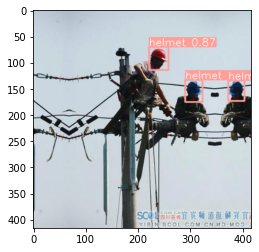

In [9]:
import os
from matplotlib import pyplot as plt
img = os.path.join('data', 'images', 'hard_hat_workers10.png')
results = model(img)
%matplotlib inline 
plt.imshow(np.squeeze(results.render()))
plt.show()

In [22]:
cap = cv2.VideoCapture('samplevideo.mp4')
count=0
while cap.isOpened():
    ret, frame = cap.read()
    count+=1
    
    # Make detections 
    results = model(frame)
    
    img = np.squeeze(results.render())
    
    cv2.imshow('YOLO', img)
    img = Image.fromarray(img)
    img.save('image'+ str(count)+'.png',quality='keep')
    if cv2.waitKey(10) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

In [23]:
img_array = []
#loop through each processed image and append it into a nparray
filelist = list(sorted(glob.glob('*.png'), key=(lambda x:int(x[5:-4]))))
for filename in filelist:
    img = cv2.imread(filename)
    height, width, layers = img.shape
    size = (width,height)
    img_array.append(img)

out = cv2.VideoWriter('project1.avi',cv2.VideoWriter_fourcc(*'DIVX'), 2, size)

#converting it into a avi video
for i in range(len(img_array)):
    out.write(img_array[i])
out.release()

In [2]:
import torch
import numpy as np
import cv2
model = torch.hub.load('ultralytics/yolov5', 'custom', path='yolov5/runs/train/exp4/weights/last.pt', force_reload=True)

Downloading: "https://github.com/ultralytics/yolov5/zipball/master" to /Users/yazeedshamsudeen/.cache/torch/hub/master.zip
YOLOv5 🚀 2022-9-3 Python-3.9.12 torch-1.12.1 CPU

Fusing layers... 
Model summary: 213 layers, 7018216 parameters, 0 gradients, 15.8 GFLOPs
Adding AutoShape... 


In [8]:
from PIL import Image
import math
import os
import glob
directory = 'test'

#looping through each test image file
for filename in glob.glob('*.png'):
    img = os.path.join(directory, filename)
    
    #extracting coordinates and class name from the result
    results = model(img)
    df = results.pandas().xyxy[0]
    orig_img = Image.open(img) # open the image
    image_width = orig_img.width
    image_height = orig_img.height
    try:
        #a xml file is created with same name as the image
        with open('testlabels/'+filename.replace('png', 'xml'), 'w') as f:
            print(f)
            f.write('<annotation>\n')
            f.write('\t<folder>testlabels</folder>\n')
            f.write('\t<size>\n')
            f.write('\t\t<width>' + str(image_width) + '</width>\n')
            f.write('\t\t<height>' + str(image_height) + '</height>\n')
            f.write('\t\t<depth>3</depth>\n') # assuming a 3 channel color image (RGB)
            f.write('\t</size>\n')
            f.write('\t<segmented>0</segmented>\n')
            if len(df.index) == 0:
                f.write('</annotation>\n')
                f.close()
                continue
            #looping through the result dataframe and exctrating each bounding box information
            print(en(df.index))
            for i in range(len(df.index)):
                
                x1 = df.iloc[i]['xmin']
                y1 = df.iloc[i]['ymin']
                x2 = df.iloc[i]['xmax']
                y2 = df.iloc[i]['ymax']
                x1 = math.floor(x1)
                y1 = math.floor(y1)
                x2 = math.floor(x2)
                y2 = math.floor(y2)
                name = df.iloc[i]['name']
                
                #writing the bounding box information into the xml file
                f.write('\t<object>\n')
                f.write('\t\t<name>' + name + '</name>\n')
                f.write('\t\t<pose>Unspecified</pose>\n')
                f.write('\t\t<truncated>0</truncated>\n')
                f.write('\t\t<occluded>0</occluded>\n')
                f.write('\t\t<difficult>0</difficult>\n')
                f.write('\t\t<bndbox>\n')
                f.write('\t\t\t<xmin>' + str(x1) + '</xmin>\n')
                f.write('\t\t\t<ymin>' + str(y1) + '</ymin>\n')
                f.write('\t\t\t<xmax>' + str(x2) + '</xmax>\n')
                f.write('\t\t\t<ymax>' + str(y2) + '</ymax>\n')
                f.write('\t\t</bndbox>\n')
                f.write('\t</object>\n')
            f.write('</annotation>\n')
            f.close()
    except Exception as e:
        continue

<_io.TextIOWrapper name='testlabels/hard_hat_workers873.xml' mode='w' encoding='UTF-8'>
<_io.TextIOWrapper name='testlabels/hard_hat_workers3517.xml' mode='w' encoding='UTF-8'>
<_io.TextIOWrapper name='testlabels/hard_hat_workers3503.xml' mode='w' encoding='UTF-8'>
<_io.TextIOWrapper name='testlabels/hard_hat_workers1102.xml' mode='w' encoding='UTF-8'>
<_io.TextIOWrapper name='testlabels/hard_hat_workers4052.xml' mode='w' encoding='UTF-8'>
<_io.TextIOWrapper name='testlabels/hard_hat_workers3932.xml' mode='w' encoding='UTF-8'>
<_io.TextIOWrapper name='testlabels/hard_hat_workers4906.xml' mode='w' encoding='UTF-8'>
<_io.TextIOWrapper name='testlabels/hard_hat_workers292.xml' mode='w' encoding='UTF-8'>
<_io.TextIOWrapper name='testlabels/hard_hat_workers3489.xml' mode='w' encoding='UTF-8'>
<_io.TextIOWrapper name='testlabels/hard_hat_workers2998.xml' mode='w' encoding='UTF-8'>
<_io.TextIOWrapper name='testlabels/hard_hat_workers4331.xml' mode='w' encoding='UTF-8'>
<_io.TextIOWrapper name

<_io.TextIOWrapper name='testlabels/hard_hat_workers1563.xml' mode='w' encoding='UTF-8'>
<_io.TextIOWrapper name='testlabels/hard_hat_workers341.xml' mode='w' encoding='UTF-8'>
<_io.TextIOWrapper name='testlabels/hard_hat_workers4547.xml' mode='w' encoding='UTF-8'>
<_io.TextIOWrapper name='testlabels/hard_hat_workers221.xml' mode='w' encoding='UTF-8'>
<_io.TextIOWrapper name='testlabels/hard_hat_workers91.xml' mode='w' encoding='UTF-8'>
<_io.TextIOWrapper name='testlabels/hard_hat_workers1832.xml' mode='w' encoding='UTF-8'>
<_io.TextIOWrapper name='testlabels/hard_hat_workers4786.xml' mode='w' encoding='UTF-8'>
<_io.TextIOWrapper name='testlabels/hard_hat_workers4787.xml' mode='w' encoding='UTF-8'>
<_io.TextIOWrapper name='testlabels/hard_hat_workers2309.xml' mode='w' encoding='UTF-8'>
<_io.TextIOWrapper name='testlabels/hard_hat_workers750.xml' mode='w' encoding='UTF-8'>
<_io.TextIOWrapper name='testlabels/hard_hat_workers4591.xml' mode='w' encoding='UTF-8'>
<_io.TextIOWrapper name='t

<_io.TextIOWrapper name='testlabels/hard_hat_workers3495.xml' mode='w' encoding='UTF-8'>
<_io.TextIOWrapper name='testlabels/hard_hat_workers1321.xml' mode='w' encoding='UTF-8'>
<_io.TextIOWrapper name='testlabels/hard_hat_workers1335.xml' mode='w' encoding='UTF-8'>
<_io.TextIOWrapper name='testlabels/hard_hat_workers1123.xml' mode='w' encoding='UTF-8'>
<_io.TextIOWrapper name='testlabels/hard_hat_workers4073.xml' mode='w' encoding='UTF-8'>
<_io.TextIOWrapper name='testlabels/hard_hat_workers1877.xml' mode='w' encoding='UTF-8'>
<_io.TextIOWrapper name='testlabels/hard_hat_workers4714.xml' mode='w' encoding='UTF-8'>
<_io.TextIOWrapper name='testlabels/hard_hat_workers2365.xml' mode='w' encoding='UTF-8'>
<_io.TextIOWrapper name='testlabels/hard_hat_workers3325.xml' mode='w' encoding='UTF-8'>
<_io.TextIOWrapper name='testlabels/hard_hat_workers2985.xml' mode='w' encoding='UTF-8'>
<_io.TextIOWrapper name='testlabels/hard_hat_workers1095.xml' mode='w' encoding='UTF-8'>
<_io.TextIOWrapper na